In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import statsmodels.api as sm


font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font)


In [2]:
raw= pd.read_csv('./데이터/서울시 강수량 현황 정보.csv',encoding='cp949')
df=raw.copy()


In [3]:
df.head()
df = df.rename(columns= {
    '조사년월일': '일자',
    '측정지역' : '지역구'
})

# 기간 : 12년 1월 ~ 24년 5월
-----------------------------------------
총 데이터  : 95708개

제거 해야하는 값 
+ 강수량 없는 양 : 73950개
+ null 값 : 75개


남은 데이터 :  21683개

In [4]:
print(f'df 개수 : {len(df)}')
print(f'일일 강수량 0 개수 : {len(df[df["일일강수량"]==0.0])}')
print(f'null 값 개수 : {len(df[df["일일강수량"].isnull()])}')
print(f'지역구 개수 : {len(df["지역구"].unique())}')
print(f'{len(df)/len(df["지역구"].unique())}')

df 개수 : 95708
일일 강수량 0 개수 : 73950
null 값 개수 : 75
지역구 개수 : 27
3544.740740740741


In [5]:
# 일일강수량이 0이 아닌 행만 선택
df = df[df['일일강수량'] != 0]
print(len(df))
# 결측치가 없는 행만 선택
df = df.dropna()
print(len(df))


21758
21683


In [6]:
df

,일자,측정소이름,지역구,일일강수량
11,20240531,서대문,서대문구,1.0
110,20240526,은평,은평구,10.0
111,20240526,마포,마포구,7.5
112,20240526,영등포,영등포구,7.0
113,20240526,강북,강북구,12.5
...,...,...,...,...
95252,20120119,관악,관악구,0.5
95254,20120119,동작,동작구,0.5
95256,20120119,양천,양천구,0.5
95262,20120119,강남,강남구,0.5


# 집중 호우 기준 
+ 한시간 30mm이상 (이 데이터엔 없음)
+ 하루에 80mm이상 
+ 하루 강수량이 연간 강수량의10% 이상

전체 데이터 : 21683개 


In [7]:
# '일자'를 datetime 형식으로 변환하고 '월' 열 추가
df['일자'] = pd.to_datetime(df['일자'], format='%Y%m%d')
df['월'] = df['일자'].dt.to_period('M')

# 지역구별 월별 강수량 계산
monthly_rainfall = df.groupby(['월', '지역구'])['일일강수량'].sum().reset_index()
monthly_rainfall.columns = ['월', '지역구', '월별 강수량']

# 각 지역구별 연간 총 강수량 계산
annual_rainfall = df.groupby(['지역구', df['일자'].dt.year])['일일강수량'].sum().reset_index()
annual_rainfall.columns = ['지역구', '연도', '연간 강수량']

# 원본 데이터프레임에 연간 총 강수량 병합
df = df.merge(annual_rainfall, how='left', left_on=['지역구', df['일자'].dt.year], right_on=['지역구', '연도'])

# 집중호우 여부 계산
df['집중호우'] = np.where((df['일일강수량'] >= 80) | (df['일일강수량'] >= df['연간 강수량'] * 0.1), 1, 0)

# 월별 강수량을 원본 데이터프레임에 병합
df = df.merge(monthly_rainfall, how='left', left_on=['월', '지역구'], right_on=['월', '지역구'])

mon_df = df[['월', '지역구', '월별 강수량', '집중호우']]
day_df = df[['일자','지역구','일일강수량','집중호우']]

mon_df.head()

,월,지역구,월별 강수량,집중호우
0,2024-05,서대문구,121.0,0
1,2024-05,은평구,129.5,0
2,2024-05,마포구,115.5,0
3,2024-05,영등포구,106.5,0
4,2024-05,강북구,146.5,0


In [8]:
day_df

,일자,지역구,일일강수량,집중호우
0,2024-05-31,서대문구,1.0,0
1,2024-05-26,은평구,10.0,0
2,2024-05-26,마포구,7.5,0
3,2024-05-26,영등포구,7.0,0
4,2024-05-26,강북구,12.5,0
...,...,...,...,...
21678,2012-01-19,관악구,0.5,0
21679,2012-01-19,동작구,0.5,0
21680,2012-01-19,양천구,0.5,0
21681,2012-01-19,강남구,0.5,0


In [9]:
len(df[df['집중호우']==1])

791

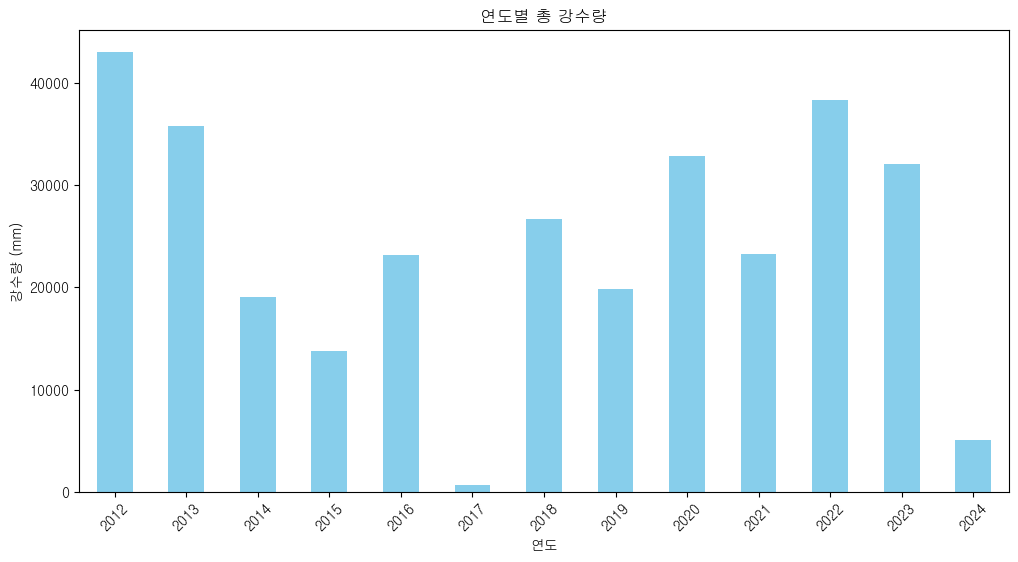

In [10]:
import matplotlib.pyplot as plt

# 연도별 총 강수량 계산
annual_rainfall = df.groupby(df['일자'].dt.year)['일일강수량'].sum()

# 연도별 강수량 시각화
plt.figure(figsize=(12, 6))
annual_rainfall.plot(kind='bar', color='skyblue')
plt.title('연도별 총 강수량')
plt.xlabel('연도')
plt.ylabel('강수량 (mm)')
plt.xticks(rotation=45)
plt.show()


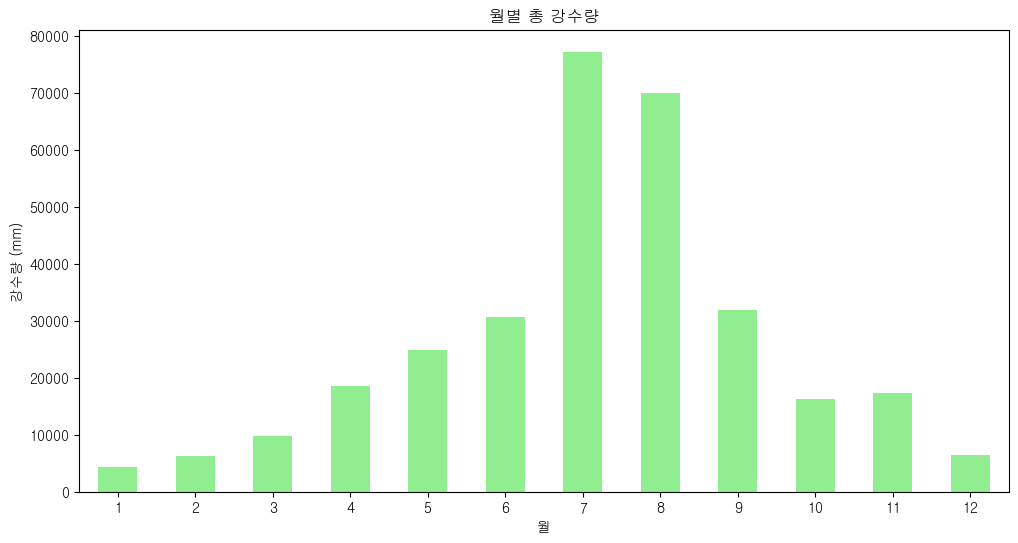

In [11]:
# 월별 총 강수량 계산 (1월부터 12월까지)
monthly_rainfall = df.groupby(df['일자'].dt.month)['일일강수량'].sum()

# 월별 강수량 시각화
plt.figure(figsize=(12, 6))
monthly_rainfall.plot(kind='bar', color='lightgreen')
plt.title('월별 총 강수량')
plt.xlabel('월')
plt.ylabel('강수량 (mm)')
plt.xticks(rotation=0)
plt.show()


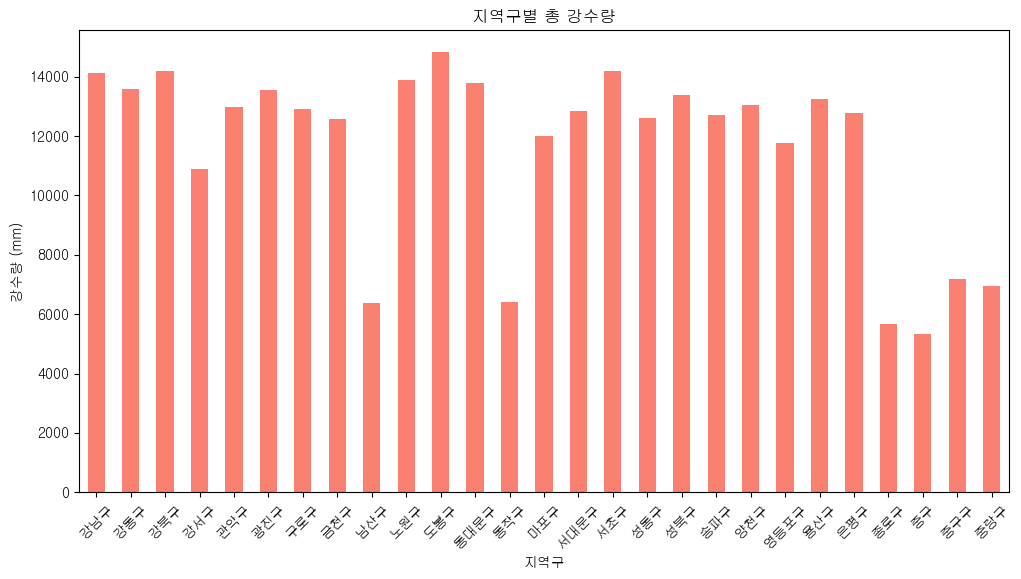

In [12]:
# 지역구별 총 강수량 계산
district_rainfall = df.groupby('지역구')['일일강수량'].sum()

# 지역구별 강수량 시각화
plt.figure(figsize=(12, 6))
district_rainfall.plot(kind='bar', color='salmon')
plt.title('지역구별 총 강수량')
plt.xlabel('지역구')
plt.ylabel('강수량 (mm)')
plt.xticks(rotation=45)
plt.show()


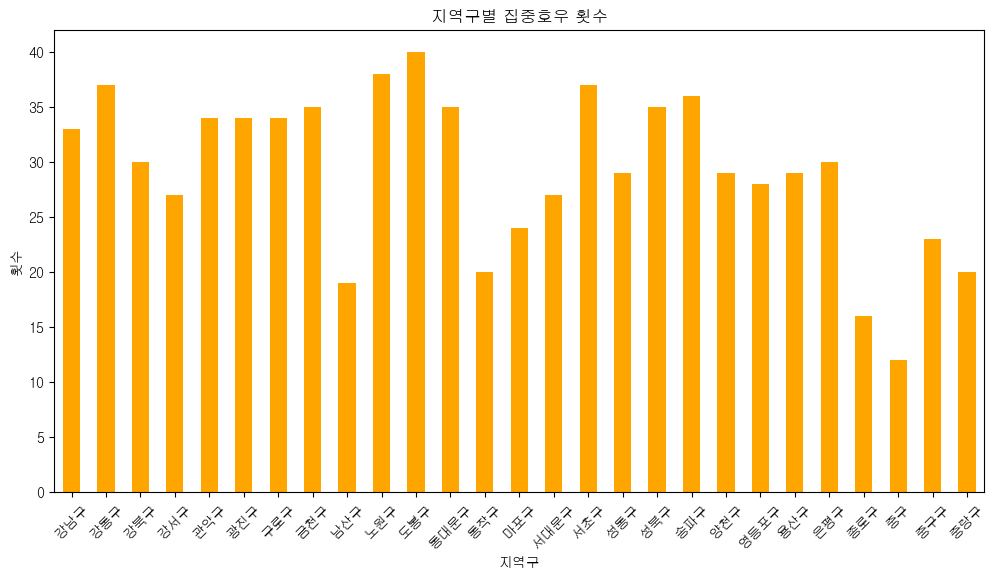

In [13]:
# 지역구별 집중호우 횟수 계산
heavy_rain_count = df[df['집중호우'] == 1].groupby('지역구').size()

# 지역구별 집중호우 횟수 시각화
plt.figure(figsize=(12, 6))
heavy_rain_count.plot(kind='bar', color='orange')
plt.title('지역구별 집중호우 횟수')
plt.xlabel('지역구')
plt.ylabel('횟수')
plt.xticks(rotation=45)
plt.show()

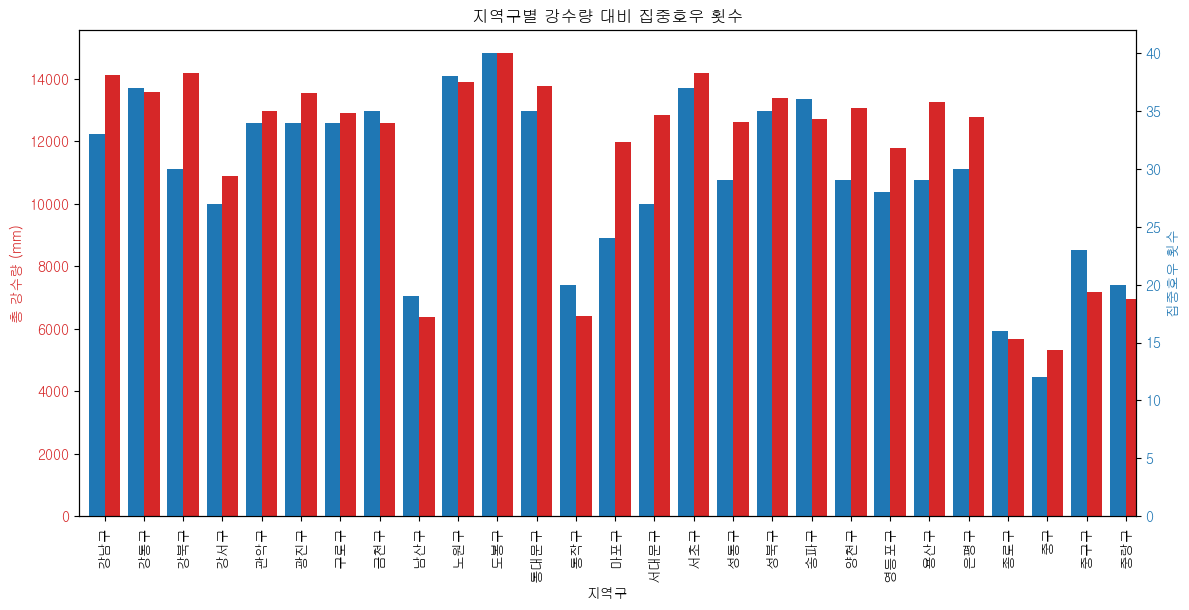

In [14]:
# 지역구별 총 강수량 계산
district_rainfall = df.groupby('지역구')['일일강수량'].sum()

# 지역구별 집중호우 횟수 계산
heavy_rain_count = df[df['집중호우'] == 1].groupby('지역구').size()

# 지역구별 강수량 대비 집중호우 횟수 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('지역구')
ax1.set_ylabel('총 강수량 (mm)', color=color)
district_rainfall.plot(kind='bar', ax=ax1, color=color, position=0, width=0.4)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('집중호우 횟수', color=color)
heavy_rain_count.plot(kind='bar', ax=ax2, color=color, position=1, width=0.4)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('지역구별 강수량 대비 집중호우 횟수')
plt.show()


In [15]:
mon_df

,월,지역구,월별 강수량,집중호우
0,2024-05,서대문구,121.0,0
1,2024-05,은평구,129.5,0
2,2024-05,마포구,115.5,0
3,2024-05,영등포구,106.5,0
4,2024-05,강북구,146.5,0
...,...,...,...,...
21678,2012-01,관악구,5.0,0
21679,2012-01,동작구,1.0,0
21680,2012-01,양천구,5.5,0
21681,2012-01,강남구,5.5,0


In [17]:
# '월' 컬럼을 문자열로 변환
mon_df['월'] = mon_df['월'].astype(str)

# '월' 컬럼에서 연도만 추출하여 '연도' 컬럼 생성
mon_df['연도'] = mon_df['월'].str.slice(0, 4)

# 연도별로 집중호우 횟수 계산
연도별_집중호우_수 = mon_df.groupby('연도')['집중호우'].sum()

print(연도별_집중호우_수)

연도
2012    139
2013     56
2014     17
2015      1
2016     50
2017    127
2018     59
2019     26
2020     77
2021     14
2022    132
2023     49
2024     44
Name: 집중호우, dtype: int32


C:\Users\ciw96\AppData\Local\Temp\ipykernel_31932\2845197626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mon_df['월'] = mon_df['월'].astype(str)
C:\Users\ciw96\AppData\Local\Temp\ipykernel_31932\2845197626.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mon_df['연도'] = mon_df['월'].str.slice(0, 4)


In [ ]:
len()